In [18]:
import numpy as np
import pyproj
import matplotlib.pyplot as plt
plt.rcParams["font.size"] = 20

import torch
from OkadaTorch import OkadaWrapper
okada = OkadaWrapper()

In [ ]:
# import os
# os.makedirs("figs_loss", exist_ok=True)

# Generate observation data (synthetic data + some noise)

In [20]:
# domain
lon_min, lon_max = 142, 148
lat_min, lat_max = 37, 43
dlon, dlat = 0.25, 0.25 # very sparse
nlon, nlat = int((lon_max-lon_min)/dlon)+1, int((lat_max-lat_min)/dlon)+1
lon_mid, lat_mid = (lon_min+lon_max)/2, (lat_min+lat_max)/2


# coordinate transformation
ll2xy = pyproj.Transformer.from_crs(
    crs_from="EPSG:4326", # WGS84
    crs_to=f"+proj=tmerc +lon_0={lon_mid} +lat_0={lat_mid} +ellps=WGS84 +datum=WGS84 +units=km", 
    always_xy=True
)

lon = np.linspace(lon_min, lon_max, nlon)
lat = np.linspace(lat_min, lat_max, nlat)
Lon, Lat = np.meshgrid(lon, lat)
x_obs, y_obs = ll2xy.transform(Lon, Lat)
X_obs = torch.from_numpy(x_obs)
Y_obs = torch.from_numpy(y_obs)

X_min, X_max = X_obs.min(), X_obs.max()
Y_min, Y_max = Y_obs.min(), Y_obs.max()
dX, dY = (X_max - X_min) / 2, (Y_max - Y_min) / 2
print(dX.item(), dY.item())


coords = {
    "x": X_obs,
    "y": Y_obs
}

267.0689477487547 335.28939693235236


In [21]:
# source parameters
lat_fault = 40.2224
lon_fault = 144.8678
x_fault, y_fault = ll2xy.transform(lon_fault, lat_fault)

print(x_fault, y_fault) # km

params_true = {
    "x_fault": torch.tensor(x_fault),
    "y_fault": torch.tensor(y_fault),
    "depth": torch.tensor(0.1), # km
    "length": torch.tensor(218.0), # km
    "width": torch.tensor(46.0), # km
    "strike": torch.tensor(189.0), # degree
    "dip": torch.tensor(60.0), # degree
    "rake": torch.tensor(270.0), # degree
    "slip": torch.tensor(5.62) # m
}


print("True parameters:")

for name in params_true.keys():
    value = params_true[name].item()
    print(name, value)

-11.25235992480785 24.70296061567198
True parameters:
x_fault -11.252360343933105
y_fault 24.702960968017578
depth 0.10000000149011612
length 218.0
width 46.0
strike 189.0
dip 60.0
rake 270.0
slip 5.619999885559082


In [22]:
ux_obs, uy_obs, uz_obs = okada.compute(coords, params_true, compute_strain=False, is_degree=True, fault_origin="topleft") 

rng = np.random.default_rng(seed=123)
err = 0.05 * rng.standard_normal((nlon, nlat, 3))

ux_obs += err[:, :, 0]
uy_obs += err[:, :, 1]
uz_obs += err[:, :, 2]

/tmp/ipykernel_2135250/3736596243.py:6: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  ux_obs += err[:, :, 0]
/tmp/ipykernel_2135250/3736596243.py:7: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  uy_obs += err[:, :, 1]
/tmp/ipykernel_2135250/3736596243.py:8: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  uz_obs += err[:, :, 2]


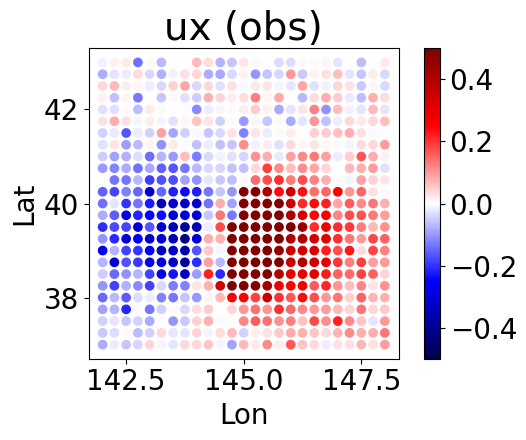

In [23]:
fig, ax = plt.subplots()
im = ax.scatter(Lon, Lat, c=ux_obs, cmap="seismic", vmin=-0.5, vmax=0.5)
ax.set_aspect("equal")
ax.set_xlabel("Lon")
ax.set_ylabel("Lat")
ax.set_title("ux (obs)", fontsize=28)
fig.colorbar(im)
fig.show()
# plt.tight_layout()
# fig.savefig("figs_loss/ux_obs.png")

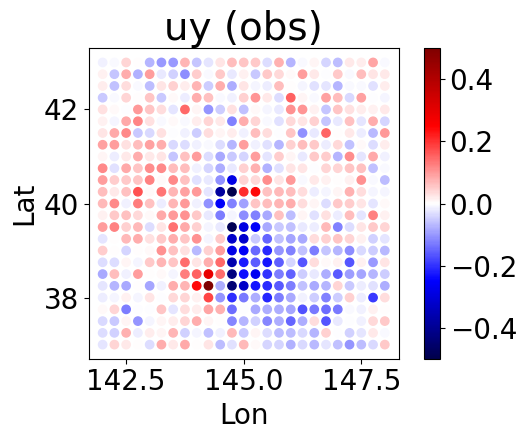

In [24]:
fig, ax = plt.subplots()
im = ax.scatter(Lon, Lat, c=uy_obs, cmap="seismic", vmin=-0.5, vmax=0.5)
ax.set_aspect("equal")
ax.set_xlabel("Lon")
ax.set_ylabel("Lat")
ax.set_title("uy (obs)", fontsize=28)
fig.colorbar(im)
fig.show()
# plt.tight_layout()
# fig.savefig("figs_loss/uy_obs.png")

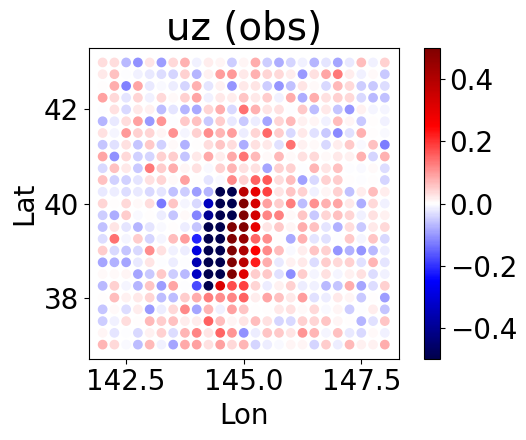

In [25]:
fig, ax = plt.subplots()
im = ax.scatter(Lon, Lat, c=uz_obs, cmap="seismic", vmin=-0.5, vmax=0.5)
ax.set_aspect("equal")
ax.set_xlabel("Lon")
ax.set_ylabel("Lat")
ax.set_title("uz (obs)", fontsize=28)
fig.colorbar(im)
fig.show()
# plt.tight_layout()
# fig.savefig("figs_loss/uz_obs.png")

# Gradient-based parameter estimation

For a successful optimization, it is desirable for the gradients with respect to each parameter to have the same order of magnitude.
Here, we perform a simple scaling: for each parameter `p`, we set a representative value `p0` and width `dp` in advance, and optimize the normalized parameter `q = (p-p0)/dp`.


[NOTE]

For some parameters (especially `x_fault` and `y_fault`), choise of initial values can greatly affect the results;
if they are chosen too far from the optimal values, the optimization will fail (the solution will diverge). 
In practical cases, it may be safer to keep those variables fixed at some values (= set `requires_grad=False`) and optimize only the other parameters.

The purpose here is only to demonstrate conceptually that optimization is possible using gradients obtained by automatic differentiation.
Actual applications would require more techniques.

In [26]:
def scale(p, p0, dp):
    q = {}
    for key in p:
        q[key] = ((p[key] - p0[key]) / dp[key]).detach().clone().requires_grad_(True)
    return q

def unscale(q, p0, dp):
    p = {}
    for key in q:
        p[key] = p0[key] + dp[key] * q[key]
    return p

In [27]:
# parameters; target of optimization (SPECIFY `requires_grad=True` !)
# choose appropriate initial values
params = {
    "x_fault": torch.tensor(0.0, requires_grad=True),  
    "y_fault": torch.tensor(10.0, requires_grad=True),
    "depth": torch.tensor(1.0, requires_grad=True),
    "length": torch.tensor(150.0, requires_grad=True),
    "width": torch.tensor(60.0, requires_grad=True),
    "strike": torch.tensor(200.0, requires_grad=True),
    "dip": torch.tensor(45.0, requires_grad=True),
    "rake": torch.tensor(300.0, requires_grad=True),
    "slip": torch.tensor(10.0, requires_grad=True)
}

# save initial parameters; this is also used as the representative value 
p0 = {key: val.clone().detach() for key, val in params.items()}

print("Initial parameters:")

for name in p0.keys():
    value = p0[name].item()
    print(name, value)


# choose appropriate width
dp = {
    "x_fault": torch.tensor(dX.item()), # scaled by domain size
    "y_fault": torch.tensor(dY.item()),
    "depth": torch.tensor(10.0),
    "length": torch.tensor(100.0),
    "width": torch.tensor(100.0),
    "strike": torch.tensor(180.0),
    "dip": torch.tensor(90.0),
    "rake": torch.tensor(180.0),
    "slip": torch.tensor(5.0)
}

Initial parameters:
x_fault 0.0
y_fault 10.0
depth 1.0
length 150.0
width 60.0
strike 200.0
dip 45.0
rake 300.0
slip 10.0


In [28]:
ux, uy, uz = okada.compute(coords, params, compute_strain=False, is_degree=True, fault_origin="topleft")

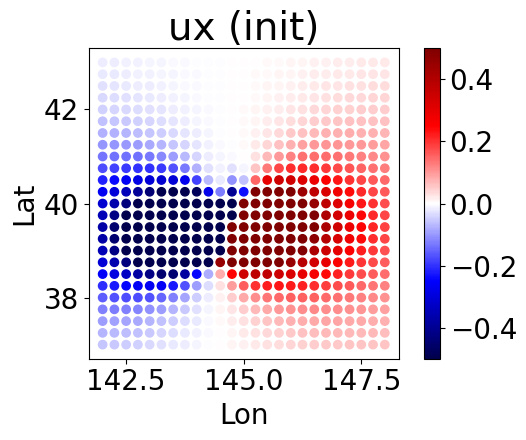

In [29]:
fig, ax = plt.subplots()
im = ax.scatter(Lon, Lat, c=ux.detach(), cmap="seismic", vmin=-0.5, vmax=0.5)
ax.set_aspect("equal")
ax.set_xlabel("Lon")
ax.set_ylabel("Lat")
ax.set_title("ux (init)", fontsize=28)
fig.colorbar(im)
fig.show()
# plt.tight_layout()
# fig.savefig("figs_loss/ux_init.png")

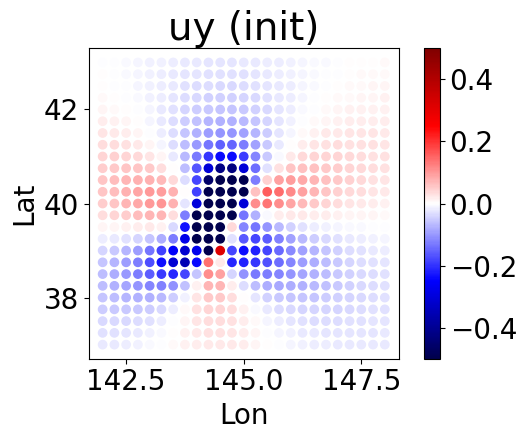

In [30]:
fig, ax = plt.subplots()
im = ax.scatter(Lon, Lat, c=uy.detach(), cmap="seismic", vmin=-0.5, vmax=0.5)
ax.set_aspect("equal")
ax.set_xlabel("Lon")
ax.set_ylabel("Lat")
ax.set_title("uy (init)", fontsize=28)
fig.colorbar(im)
fig.show()
# plt.tight_layout()
# fig.savefig("figs_loss/uy_init.png")

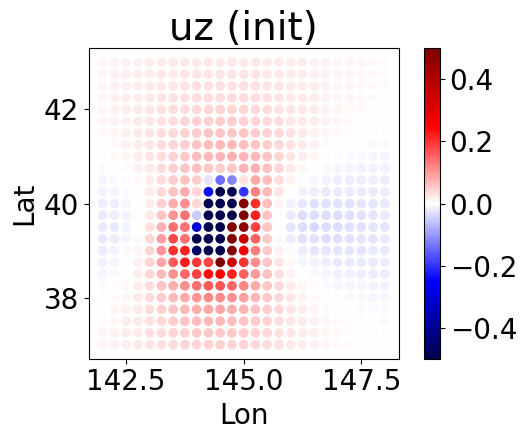

In [31]:
fig, ax = plt.subplots()
im = ax.scatter(Lon, Lat, c=uz.detach(), cmap="seismic", vmin=-0.5, vmax=0.5)
ax.set_aspect("equal")
ax.set_xlabel("Lon")
ax.set_ylabel("Lat")
ax.set_title("uz (init)", fontsize=28)
fig.colorbar(im)
fig.show()
# plt.tight_layout()
# fig.savefig("figs_loss/uz_init.png")

In [32]:
niter = 2000
l = np.zeros(niter)

# optimizer handles normalized parameters
scaled_params = scale(params, p0, dp)
optimizer = torch.optim.Adam(
    [p for p in scaled_params.values() if p.requires_grad],
)


def closure():
    # unscale
    params = unscale(scaled_params, p0, dp)
    ux, uy, uz = okada.compute(coords, params, compute_strain=False, is_degree=True, fault_origin="topleft")
    res1 = ux - ux_obs
    res2 = uy - uy_obs
    res3 = uz - uz_obs
    loss = 0.5 * (res1 * res1 + res2 * res2 + res3 * res3).sum()
    optimizer.zero_grad()
    loss.backward()
    return loss


for iter in range(niter):
    optimizer.step(closure)
    loss = closure()

    l[iter] = loss.item()

    print(f"Iteration {iter}: Loss = {loss.item()}")

Iteration 0: Loss = 96.91900762104946
Iteration 1: Loss = 95.19870593109387
Iteration 2: Loss = 93.5160574966857
Iteration 3: Loss = 93.21703244122038
Iteration 4: Loss = 92.35620797165072
Iteration 5: Loss = 90.96338895717506
Iteration 6: Loss = 89.86789694650122
Iteration 7: Loss = 89.30399468641922
Iteration 8: Loss = 88.54066315588352
Iteration 9: Loss = 87.42441505712644
Iteration 10: Loss = 86.39854390896795
Iteration 11: Loss = 85.68449452878781
Iteration 12: Loss = 85.00311348133016
Iteration 13: Loss = 84.14188756967556
Iteration 14: Loss = 83.18825022399102
Iteration 15: Loss = 82.3513986136848
Iteration 16: Loss = 81.67306575497956
Iteration 17: Loss = 80.97097323312798
Iteration 18: Loss = 80.14995508791557
Iteration 19: Loss = 79.32347948745311
Iteration 20: Loss = 78.60497010186803
Iteration 21: Loss = 77.94803257542343
Iteration 22: Loss = 77.25160639104351
Iteration 23: Loss = 76.50315353656939
Iteration 24: Loss = 75.77357289267677
Iteration 25: Loss = 75.1136791104656

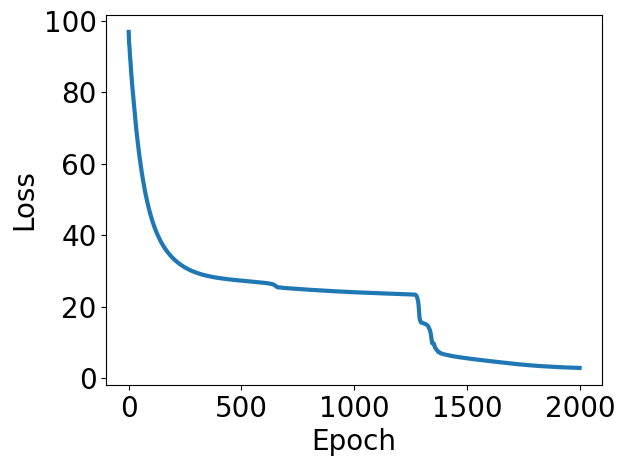

<Figure size 640x480 with 0 Axes>

In [33]:
plt.plot(l, lw=3)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()
# plt.tight_layout()
# plt.savefig("figs_loss/loss.png")

In [34]:
params = unscale(scaled_params, p0, dp)


print("[Results] true | initial | final")

for name in params.keys():
    init = p0[name].item()
    true = params_true[name].item()
    pred = params[name].item()
    print(f"{name}: {true} | {init} | {pred}")


ux, uy, uz = okada.compute(coords, params, compute_strain=False, is_degree=True, fault_origin="topleft")

[Results] true | initial | final
x_fault: -11.252360343933105 | 0.0 | -12.927599906921387
y_fault: 24.702960968017578 | 10.0 | 23.069503784179688
depth: 0.10000000149011612 | 1.0 | 0.6045831441879272
length: 218.0 | 150.0 | 210.4227294921875
width: 46.0 | 60.0 | 41.67115020751953
strike: 189.0 | 200.0 | 189.1171112060547
dip: 60.0 | 45.0 | 59.80945587158203
rake: 270.0 | 300.0 | 269.5846862792969
slip: 5.619999885559082 | 10.0 | 6.136780738830566


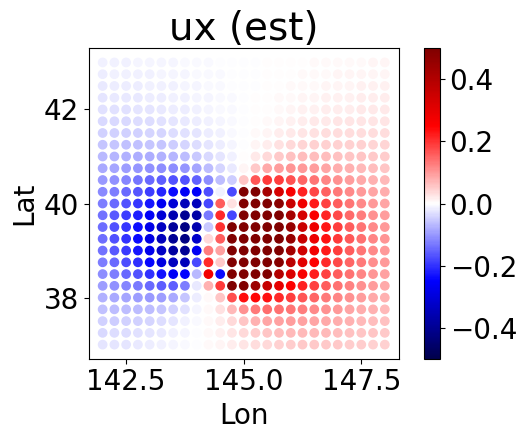

In [35]:
fig, ax = plt.subplots()
im = ax.scatter(Lon, Lat, c=ux.detach(), cmap="seismic", vmin=-0.5, vmax=0.5)
ax.set_aspect("equal")
ax.set_xlabel("Lon")
ax.set_ylabel("Lat")
ax.set_title("ux (est)", fontsize=28)
fig.colorbar(im)
fig.show()
# plt.tight_layout()
# fig.savefig("figs_loss/ux_est.png")

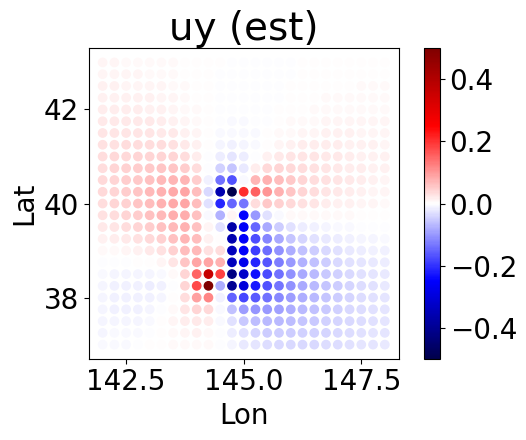

In [36]:
fig, ax = plt.subplots()
im = ax.scatter(Lon, Lat, c=uy.detach(), cmap="seismic", vmin=-0.5, vmax=0.5)
ax.set_aspect("equal")
ax.set_xlabel("Lon")
ax.set_ylabel("Lat")
ax.set_title("uy (est)", fontsize=28)
fig.colorbar(im)
fig.show()
# plt.tight_layout()
# fig.savefig("figs_loss/uy_est.png")

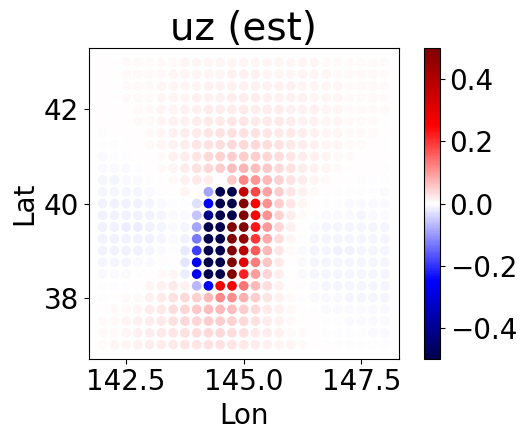

In [37]:
fig, ax = plt.subplots()
im = ax.scatter(Lon, Lat, c=uz.detach(), cmap="seismic", vmin=-0.5, vmax=0.5)
ax.set_aspect("equal")
ax.set_xlabel("Lon")
ax.set_ylabel("Lat")
ax.set_title("uz (est)", fontsize=28)
fig.colorbar(im)
fig.show()
# plt.tight_layout()
# fig.savefig("figs_loss/uz_est.png")